In [1]:
%matplotlib inline
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import glob
# from focal import Focal, focal_to_spike, spike_trains_to_images_g
from scipy.signal import convolve2d
from scipy import misc
import cv2

def slice2str(s, e):
    return "{}: {}".format(s, e)

def _to_str(rs, re, cs, ce):
    return "{}, {}".format(slice2str(rs, re), slice2str(cs, ce))

def convolve(img, conv1d):
    return cv2.sepFilter2D(img, -1, conv1d, conv1d)

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:
    
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

### Compute the sampling kernel (the receptive field of neurons)

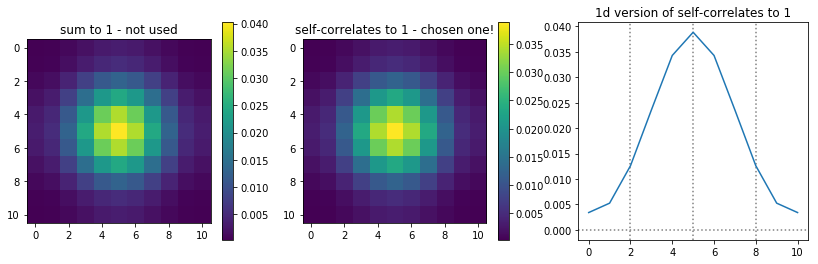

In [2]:
kwidth = 11
std = 2
stride = 3#max(1, kwidth // 7)

img = np.zeros((kwidth, kwidth))
img[kwidth//2, kwidth//2] = 1.0
conv = cv2.GaussianBlur(img, (kwidth, kwidth), std)
# conv1 = conv / np.sqrt(np.sum(conv**2))
conv1 = conv / np.sum(conv)
g1d = conv1[kwidth//2, :]

plt.figure(figsize=(14, 4))
ax = plt.subplot(1, 3, 1)
ax.set_title("sum to 1 - not used")
im = plt.imshow(conv)
plt.colorbar(im)

ax = plt.subplot(1, 3, 2)
ax.set_title("self-correlates to 1 - chosen one!")
im = plt.imshow(conv1)
plt.colorbar(im)

ax = plt.subplot(1, 3, 3)
ax.set_title("1d version of self-correlates to 1")
plt.axhline(0, color='gray', linestyle=':')
plt.axvline(g1d.size//2, color='gray', linestyle=':')
plt.axvline(g1d.size//4, color='gray', linestyle=':')
plt.axvline(3*g1d.size//4, color='gray', linestyle=':')
plt.plot(g1d)
plt.show()

### Compute the correlation between sampling kernels. This is used as a measure of how much inhibition output neurons will excert on each other.

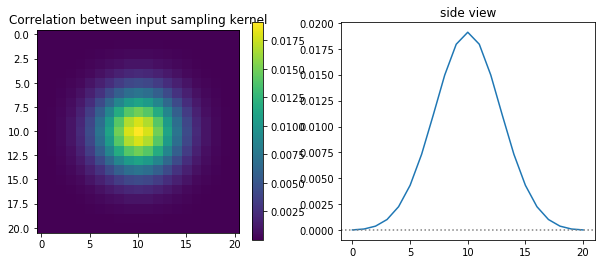

In [3]:
corr = convolve2d(conv1, conv1)
# corr *= 1./corr.max()
c1d = corr[corr.shape[0]//2, :]


plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 2, 1)
ax.set_title('Correlation between input sampling kernel')
im = plt.imshow(corr)
plt.colorbar(im)

ax = plt.subplot(1, 2, 2)
ax.set_title('side view')
plt.plot(c1d)
plt.axhline(0, color='gray', linestyle=':')

plt.show()


---
### Load test image (either Lena (R), racoon or one of the Kodak Lossless True Color Image Suite in PNG format)

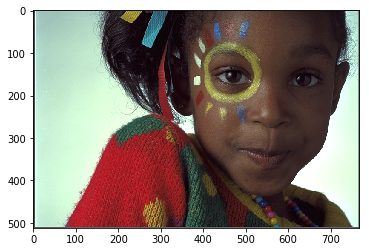

In [4]:
image_files = sorted( glob.glob('../test_images/*.png') )
face = cv2.cvtColor( cv2.imread(image_files[15]), cv2.COLOR_BGR2RGB ).astype('float')
face /= 255.0
# face = misc.face() / 255.0
# face = misc.face() / 1.0
# print(dir(misc))
plt.figure()
plt.imshow(face)
plt.show()

---

Compute achromatic version of the image and visualize along with channels

In [5]:
### channel ids
RED, GREEN, BLUE, YELLOW = range(4)

### weights for achromatic (grayscale) version
ARED, ABLUE = 0.299, 0.114
AGREEN = 1.0 - ARED - ABLUE
YMAX = 1.0
# YRED, YGREEN = 0.375, 0.425
YRED, YGREEN = 0.425, 0.375
YRED, YGREEN = 0.475, 0.525
YRED, YGREEN = 1., 1.
YSUM = YRED + YGREEN
YRED, YGREEN = (YMAX * YRED)/YSUM, (YMAX * YGREEN)/YSUM
YSUM = YMAX
print(YRED, YGREEN)
print(AGREEN)
print(1-AGREEN)

0.5 0.5
0.5870000000000001
0.4129999999999999


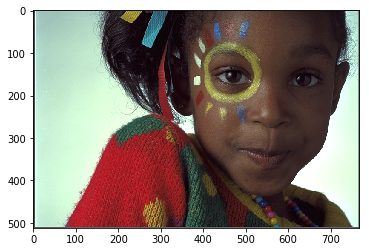

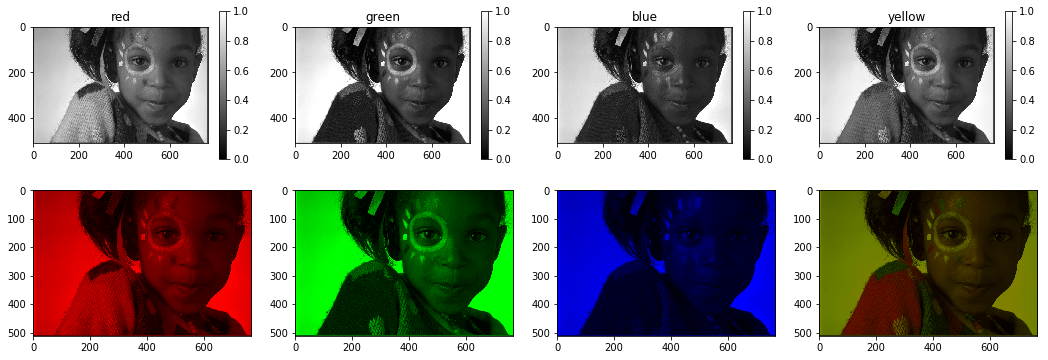

In [6]:
achromatic = face[:, :, RED] * ARED + face[:, :, GREEN] * AGREEN + face[:, :, BLUE] * ABLUE

red = face[:, :, RED]
red2 = face.copy()
red2[:, :, GREEN] = 0
red2[:, :, BLUE] = 0

green = face[:, :, GREEN]
green2 = face.copy()
green2[:, :, RED] = 0
green2[:, :, BLUE] = 0

blue = face[:, :, BLUE]
blue2 = face.copy()
blue2[:, :, RED] = 0
blue2[:, :, GREEN] = 0

yellow = red * YRED + green * YGREEN
yellow2 = face.copy()
yellow2[:, :, BLUE] = 0
yellow2[:, :, RED] *= YRED
yellow2[:, :, GREEN] *= YGREEN


vmax = 1.0 # np.max([red.max(), green.max(), blue.max(), yellow.max()])

plt.figure()
plt.imshow(face, cmap='gray')

fw = 6
plt.figure(figsize=(3*fw, fw))

ax = plt.subplot(2, 4, 1)
ax.set_title('red')
im = plt.imshow(red, cmap='gray', vmax=vmax)
plt.colorbar(im)

ax = plt.subplot(2, 4, 2)
ax.set_title('green')
im = plt.imshow(green, cmap='gray', vmax=vmax)
plt.colorbar(im)

ax = plt.subplot(2, 4, 3)
ax.set_title('blue')
im = plt.imshow(blue, cmap='gray', vmax=vmax)
plt.colorbar(im)

ax = plt.subplot(2, 4, 4)
ax.set_title('yellow')
im = plt.imshow(yellow, cmap='gray', vmax=vmax)
plt.colorbar(im)


plt.subplot(2, 4, 5)
plt.imshow(red2)

plt.subplot(2, 4, 6)
plt.imshow(green2)

plt.subplot(2, 4, 7)
plt.imshow(blue2)

plt.subplot(2, 4, 8)
plt.imshow(yellow2)

plt.show()

---
Compute sub-sampling coordinates (will be used later as a cache)

In [7]:
start = kwidth//2
h = np.arange(start, blue.shape[0], stride)
w = np.arange(start, blue.shape[1], stride)

n_w = len(w)
n_h = len(h)
rows = np.repeat(h, n_w)
cols = np.tile(w, n_h)




In [8]:
# sample (receptive field)
blue_g = convolve(blue, g1d)
red_g = convolve(red, g1d)
green_g = convolve(green, g1d)
yellow_g = convolve(yellow, g1d)
achromatic_g = convolve(achromatic, g1d)

blue_g *= 1./blue_g.max()
red_g *= 1./red_g.max()
green_g *= 1./green_g.max()
yellow_g *= (YSUM)/yellow_g.max()
achromatic_g *= 1./achromatic_g.max()

#reduce from a full image (photoreceptors?) to fewer output neurons
blue_gs = blue_g[rows, cols].reshape(n_h, n_w)
red_gs = red_g[rows, cols].reshape(n_h, n_w)
green_gs = green_g[rows, cols].reshape(n_h, n_w)
yellow_gs = yellow_g[rows, cols].reshape(n_h, n_w)
achromatic_gs = achromatic_g[rows, cols].reshape(n_h, n_w)


In [9]:
print(np.mean(red) / np.mean(red_gs))
print(np.mean(green) / np.mean(green_gs))
print(np.mean(blue) / np.mean(blue_gs))
print(np.mean(yellow) / np.mean(yellow_gs))

#average pixel value doubled after convolution, we may want to rescale

0.9971461990319757
0.9985530094156839
0.9996461280256678
0.997806910031136


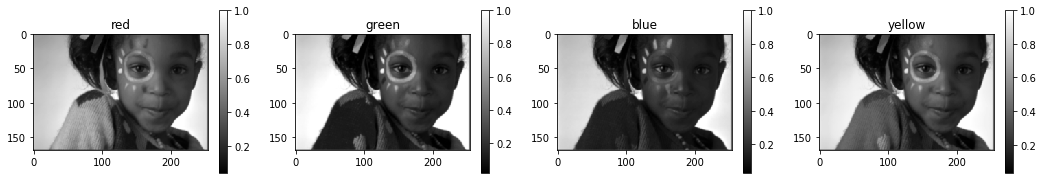

In [10]:
plt.figure(figsize=(3*fw, 0.5*fw))

vmax = np.mean([red_gs.max(), green_gs.max(), blue_gs.max()])
ax = plt.subplot(1, 4, 1)
ax.set_title("red")
im = plt.imshow(red_gs, cmap='gray', vmax=vmax)
plt.colorbar(im)

ax = plt.subplot(1, 4, 2)
ax.set_title("green")
im = plt.imshow(green_gs, cmap='gray', vmax=vmax)
plt.colorbar(im)

ax = plt.subplot(1, 4, 3)
ax.set_title("blue")
im = plt.imshow(blue_gs, cmap='gray', vmax=vmax)
plt.colorbar(im)

ax = plt.subplot(1, 4, 4)
ax.set_title("yellow")
im = plt.imshow(yellow_gs, cmap='gray', vmax=vmax)
plt.colorbar(im)


plt.show()

---

Make colours compete!
---

---
Core of the conversion method. Each output neuron will compete with its neighbours by inhibiting by how much of their input is shared (i.e. the correlation kernel). This inhibition is done taking into account the geometry and placement of the neurons.


In [11]:
def local_adjust(val, coord, img, corr):
    hw = corr.shape[0]//2
    img_r0, img_rn = max(0, coord[0] - hw), min(img.shape[0], coord[0] + hw + 1)
    img_c0, img_cn = max(0, coord[1] - hw), min(img.shape[1], coord[1] + hw + 1)
    
    cor_r0, cor_rn = coord[0] - hw, coord[0] + hw + 1
    cor_r0 = np.abs(cor_r0) if cor_r0 < 0 else 0
    cor_rn = corr.shape[0] - (cor_rn - img.shape[0]) if cor_rn > img.shape[0] else corr.shape[0]

    cor_c0, cor_cn = coord[1] - hw, coord[1] + hw + 1
    cor_c0 = np.abs(cor_c0) if cor_c0 < 0 else 0
    cor_cn = corr.shape[1] - (cor_cn - img.shape[1]) if cor_cn > img.shape[1] else corr.shape[1]

    img[img_r0:img_rn, img_c0:img_cn] -= (corr[cor_r0:cor_rn, cor_c0:cor_cn] * val)
    
    return img

def adjust_by_correlation(coord, win_key, images, correlations, fuzzy=10):
    keys = list(images.keys())
    v = float(images[win_key][coord[0], coord[1]])
    w = 1.#float(len(keys))
    
    """Adjust every channel given the winning output neuron"""
    for k in keys:
        corr = correlations[win_key][k]
        if k == win_key:
            """If the current output cell group (k) is of the winning class (win_key),
            inhibit it's neighbours via correlation kernel
            """
            images[k][:] = local_adjust(v, coord, images[k], corr)
            """Mark the current winning cell as inactive or in a recovery state (-inf) 
            """
            images[k][coord[0], coord[1]] -= np.inf

        elif (v - images[k][coord[0], coord[1]]) > fuzzy:
            """If the current output cell group (k) is NOT of the winning class (win_key)
            and it wins by a difference greater than a threshold (fuzzy), 
            mark the appropriate cell (coord[row, col]) as inhibited (-inf)
            """
            images[k][:] = local_adjust(v*w, coord, images[k], corr)
            
#             images[k][coord[0], coord[1]] -= np.inf
#         else:
#             images[k][:] = local_adjust(v, coord, images[k], corr)
    
    return images

1.0 1.0 1.0 1.0


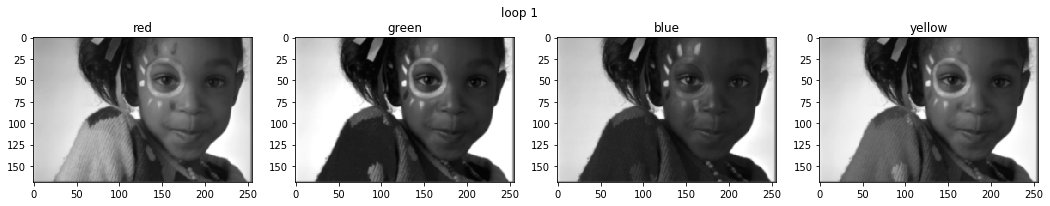

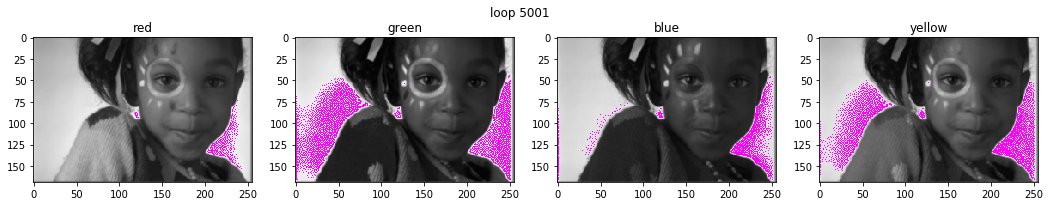

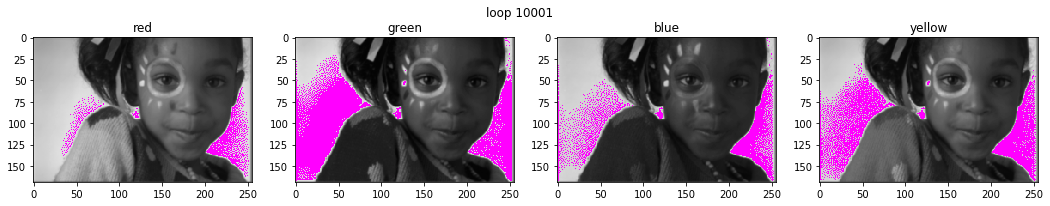

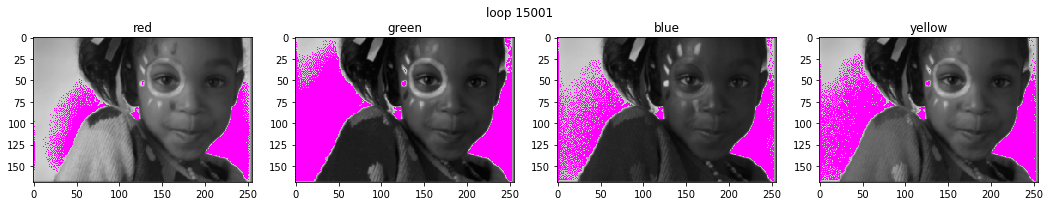

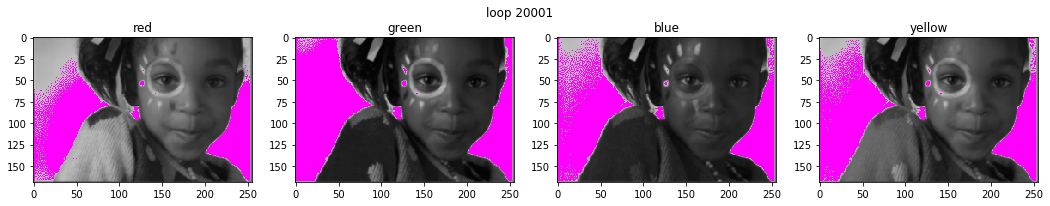

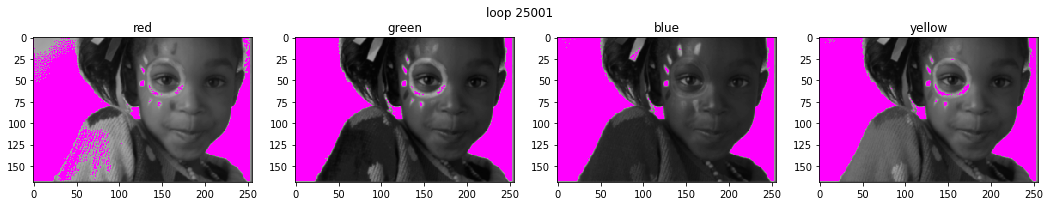

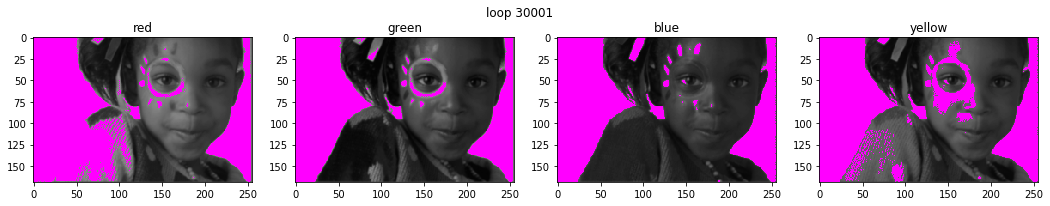

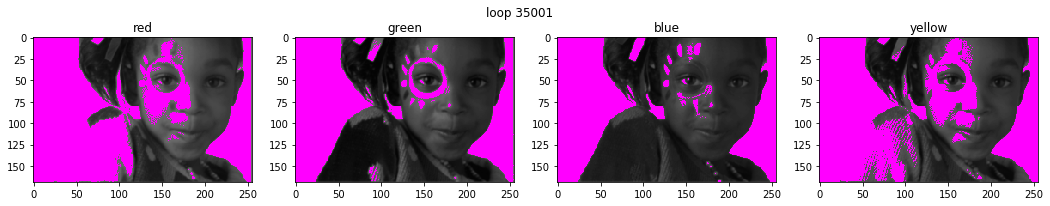

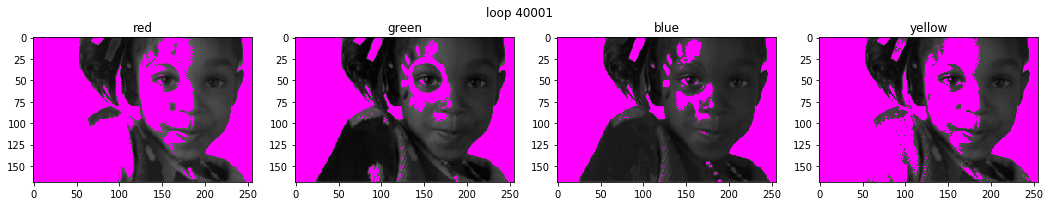

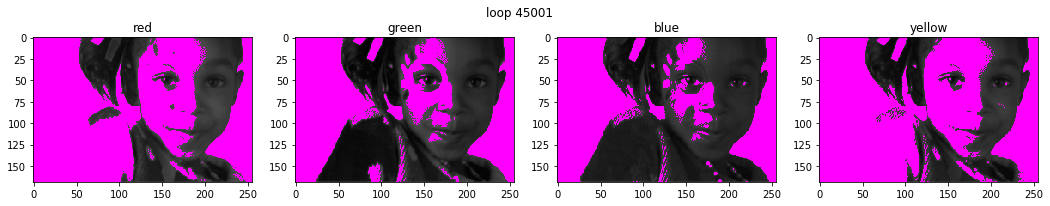

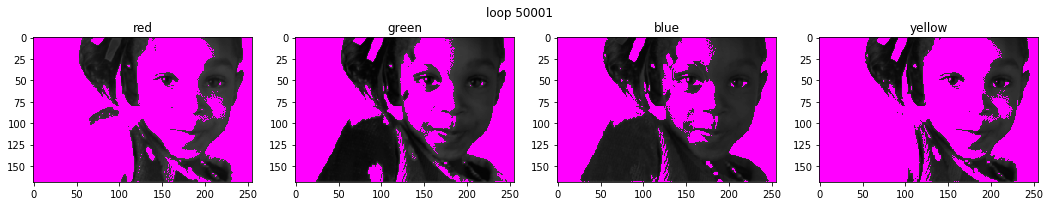

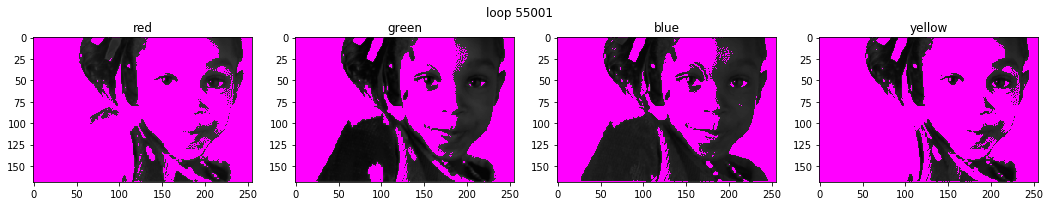

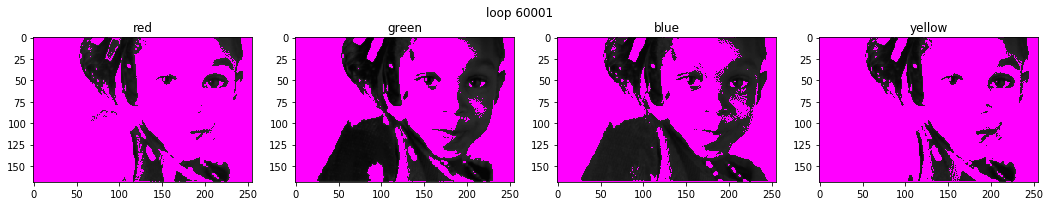

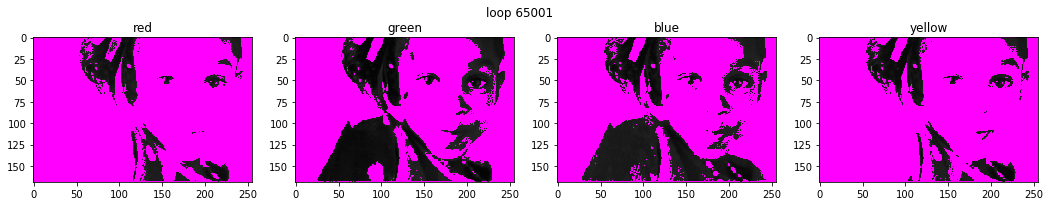

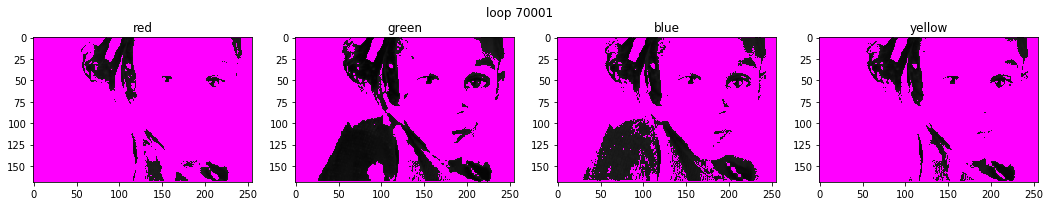

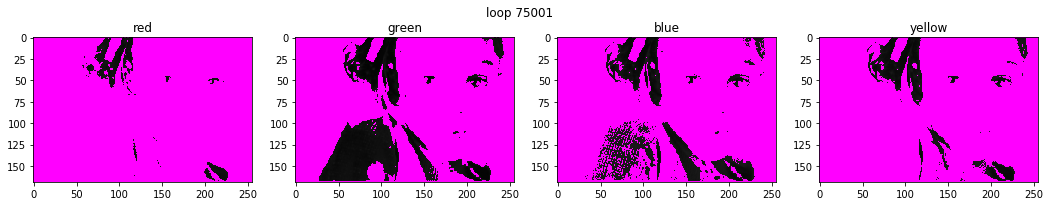

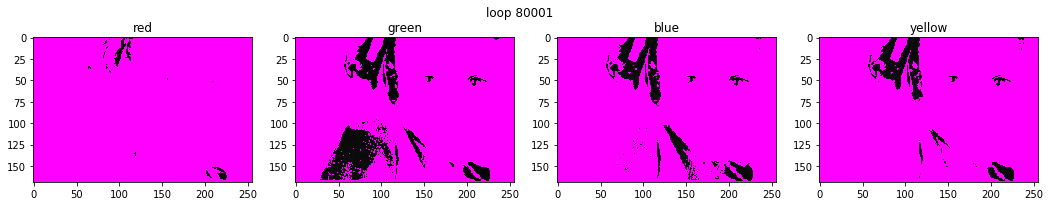

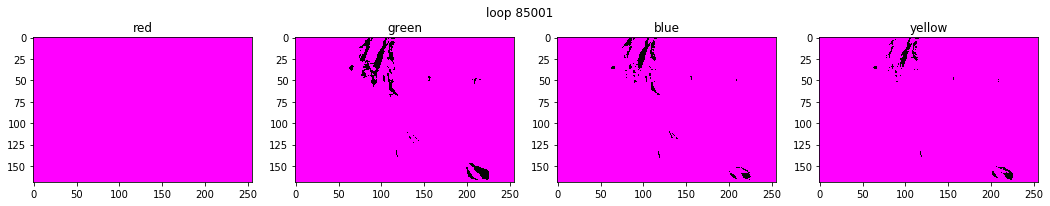

In [12]:
_cmap = matplotlib.cm.get_cmap('gray')
# _cmap.set_bad(color='black')
_cmap.set_bad(color='magenta')

blue_gs = blue_g[rows, cols].reshape(n_h, n_w)
red_gs = red_g[rows, cols].reshape(n_h, n_w)
green_gs = green_g[rows, cols].reshape(n_h, n_w)
yellow_gs = yellow_g[rows, cols].reshape(n_h, n_w)

rmax = np.abs(red_gs).max()
gmax = np.abs(green_gs).max()
bmax = np.abs(blue_gs).max()
ymax = np.abs(yellow_gs).max()
print(rmax, gmax, bmax, ymax)
mmax = np.max([rmax, gmax, bmax, ymax])

rr = np.zeros_like(red)
gg = rr.copy()
bb = rr.copy()
yy = rr.copy()

plot_idx = 5000
R, G, B, Y = range(4)
chan_list = [R, G, B, Y]
correlations = {i: {j: corr for j in chan_list} for i in chan_list}
# correlations = {i: {j: corr * 0.5 for j in chan_list} for i in chan_list}
# correlations = {i: {j: corr/corr.sum() for j in chan_list} for i in chan_list}
h0, w0 = red.shape

fuzzy = 0.2 * 1.0

_neuron_indices0 = []
_neuron_values0 = []
_img_indices0 = []

_neuron_indices1 = []
_neuron_values1 = []
_img_indices1 = []
_colors0 = np.append(red_gs.flatten(), green_gs.flatten())
_colors1 = np.append(blue_gs.flatten(), yellow_gs.flatten())

for i in range(int(1. * n_h * n_w * 2)):
#     print(i)
    _colors0[:] = np.append(red_gs.flatten(), green_gs.flatten())
    _colors1[:] = np.append(blue_gs.flatten(), yellow_gs.flatten())

    _max_idx0 = np.argmax(_colors0)
    _max_idx1 = np.argmax(_colors1)
    
    if _colors0[_max_idx0] <= 0 or _colors1[_max_idx1] <= 0:# or \
        #_colors0[_max_idx0] < fuzzy or _colors1[_max_idx1] < fuzzy:
        print("less than fuzzy")
        break

    _neuron_values0.append(_colors0[_max_idx0])
    _img_idx0 = _max_idx0 // (n_w * n_h)
    _img_indices0.append(_img_idx0)
    _max_idx0 -= _img_idx0 * n_w * n_h 
    _neuron_indices0.append(_max_idx0)
    _mr0 = rows[_max_idx0]
    _mc0 = cols[_max_idx0]

    _neuron_values1.append(_colors1[_max_idx1])
    _img_idx1 = _max_idx1 // (n_w * n_h)
    _img_indices1.append(_img_idx1)
    _max_idx1 -= _img_idx1 * n_w * n_h 
    _neuron_indices1.append(_max_idx1)
    _mr1 = rows[_max_idx1]
    _mc1 = cols[_max_idx1]

    rr[:] = -np.inf
    gg[:] = -np.inf
    bb[:] = -np.inf
    yy[:] = -np.inf
    
    rr[rows, cols] = red_gs.flatten()
    gg[rows, cols] = green_gs.flatten()
    bb[rows, cols] = blue_gs.flatten()
    yy[rows, cols] = yellow_gs.flatten()
    
    if ((i) % plot_idx) == 0:
        
        fig = plt.figure(figsize=(3*fw, 0.5*fw))
        plt.suptitle('loop %d'%(i+1))
        ax = plt.subplot(1, 4, 1)
        ax.set_title('red')
        plt.imshow(red_gs.copy(), cmap=_cmap, vmin=0, vmax=mmax)

        ax = plt.subplot(1, 4, 2)
        ax.set_title('green')
        plt.imshow(green_gs.copy(), cmap=_cmap, vmin=0, vmax=mmax)

        ax = plt.subplot(1, 4, 3)
        ax.set_title('blue')
        plt.imshow(blue_gs.copy(), cmap=_cmap, vmin=0, vmax=mmax)

        ax = plt.subplot(1, 4, 4)
        ax.set_title('yellow')
        plt.imshow(yellow_gs.copy(), cmap=_cmap, vmin=0, vmax=mmax)

        plt.show()
    
    
    adjust_by_correlation([_mr0, _mc0], _img_idx0, {R: rr, G: gg}, correlations, fuzzy=fuzzy)
    adjust_by_correlation([_mr1, _mc1], _img_idx1, {0: bb, 1: yy}, correlations, fuzzy=fuzzy)
    
    red_gs[:] = rr[rows, cols].reshape(n_h, n_w)
    green_gs[:] = gg[rows, cols].reshape(n_h, n_w)
    blue_gs[:] = bb[rows, cols].reshape(n_h, n_w)
    yellow_gs[:] = yy[rows, cols].reshape(n_h, n_w)
    


Visualize spikes per channel

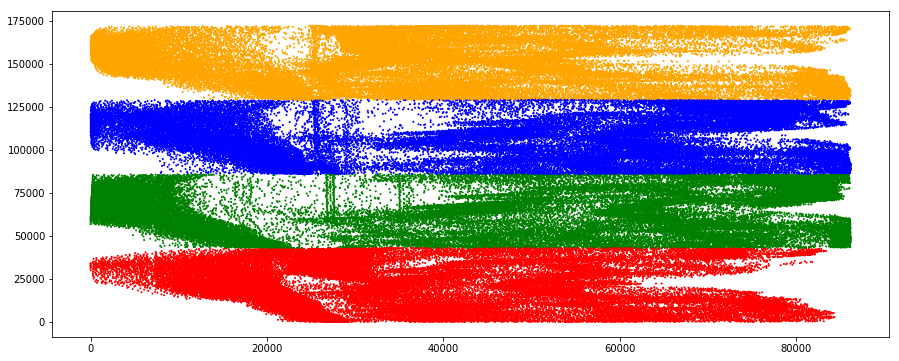

In [13]:
ccc0 = {0: 'red', 1: 'green',}
colors0 = [ccc0[_img_indices0[idx]] for idx in range(len(_neuron_indices0))]
offsets0 = np.array([_img_indices0[idx] * red_gs.size for idx in range(len(_neuron_indices0))])

ccc1 = {0: 'blue', 1: 'orange'}
colors1 = [ccc1[_img_indices1[idx]] for idx in range(len(_neuron_indices1))]
offsets1 = np.array([(_img_indices1[idx] + 2) * red_gs.size for idx in range(len(_neuron_indices1))])

plt.figure(figsize=(15, 6))
plt.scatter(np.arange(len(_neuron_indices0)), np.asarray(_neuron_indices0) + offsets0, c=colors0, s=1)
plt.scatter(np.arange(len(_neuron_indices1)), np.asarray(_neuron_indices1) + offsets1, c=colors1, s=1)
plt.show()

## Reconstruct from the spike activity

First we'll compare with the low-res version

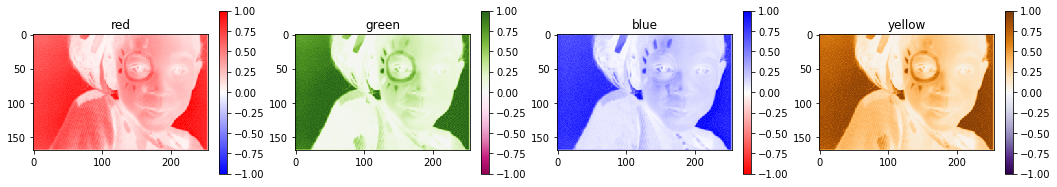

In [14]:
rn_s = np.zeros_like(red_gs)
gn_s = rn_s.copy()
bn_s = rn_s.copy()
yn_s = rn_s.copy()

h, w = rn_s.shape

for i in range(len(_neuron_indices0)):
    v = _neuron_values0[i]
    idx = _neuron_indices0[i]
    img_idx = _img_indices0[i]
    row, col = idx // w, idx % w
#     row, col = rows[idx], cols[idx]
    
    if img_idx == R:
        rn_s[row, col] = v
    elif img_idx == G:
        gn_s[row, col] = v

for i in range(len(_neuron_indices1)):
    v = _neuron_values1[i]
    idx = _neuron_indices1[i]
    img_idx = _img_indices1[i]
    row, col = idx // w, idx % w
#     row, col = rows[idx], cols[idx]

    if img_idx == 0:
        bn_s[row, col] = v
    elif img_idx == 1:
        yn_s[row, col] = v


        
plt.figure(figsize=(3*fw, 0.5*fw))
ax = plt.subplot(1, 4, 1)
ax.set_title("red")
im = plt.imshow(rn_s, cmap='bwr', vmin=-np.abs(rn_s).max(), vmax=np.abs(rn_s).max())
plt.colorbar(im)

ax = plt.subplot(1, 4, 2)
ax.set_title("green")
im = plt.imshow(gn_s, cmap='PiYG', vmin=-np.abs(gn_s).max(), vmax=np.abs(gn_s).max())
plt.colorbar(im)

ax = plt.subplot(1, 4, 3)
ax.set_title("blue")
im = plt.imshow(bn_s, cmap='bwr_r', vmin=-np.abs(bn_s).max(), vmax=np.abs(bn_s).max())
plt.colorbar(im)


ax = plt.subplot(1, 4, 4)
ax.set_title("yellow")
im = plt.imshow(yn_s, cmap='PuOr_r', vmin=-np.abs(yn_s).max(), vmax=np.abs(yn_s).max())
plt.colorbar(im)

plt.show()

1.0 1.0 1.0


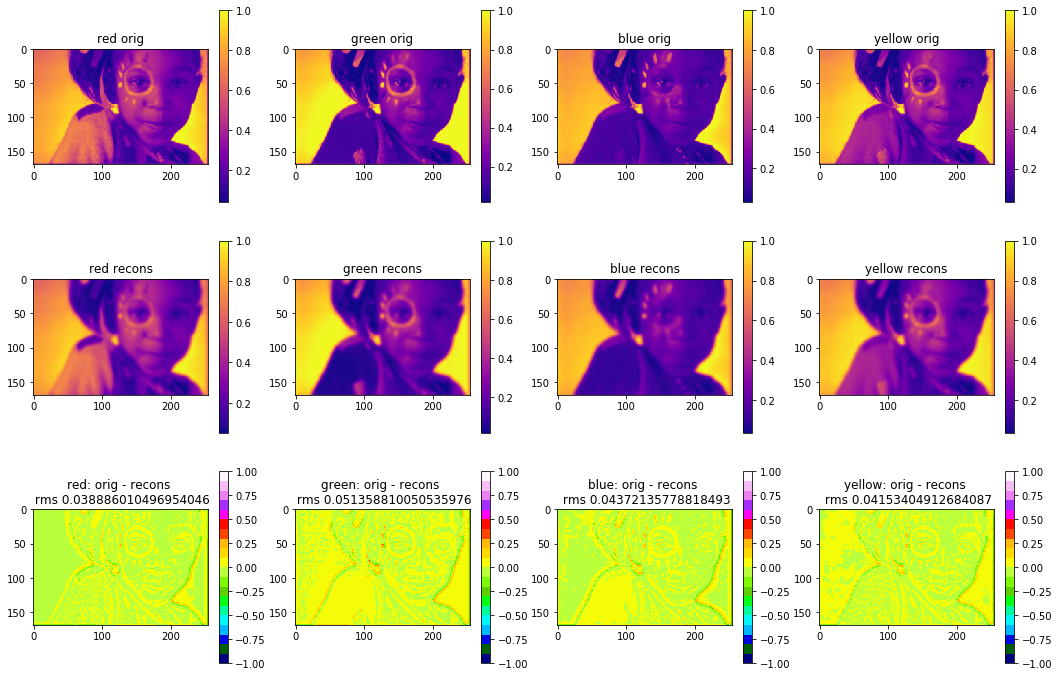

In [15]:
kernel = g1d if bool(1) else c1d

blue_gs = blue_g[rows, cols].reshape(n_h, n_w)
red_gs = red_g[rows, cols].reshape(n_h, n_w)
green_gs = green_g[rows, cols].reshape(n_h, n_w)
yellow_gs = yellow_g[rows, cols].reshape(n_h, n_w)

blue_gs *= 1.0/blue_gs.max()
red_gs *= 1.0/red_gs.max()
green_gs *= 1.0/green_gs.max()
yellow_gs *= 1.0/yellow_gs.max()


if bool(0):
    red_from_yellow = (yn_s - YGREEN * gn_s) / YRED
    green_from_yellow = (yn_s - YRED * rn_s) / YGREEN
    rn_s[:] += (rn_s == 0) * red_from_yellow
    gn_s[:] += (gn_s == 0) * green_from_yellow


if bool(1):
    rn_gs = convolve(rn_s, kernel)
    gn_gs = convolve(gn_s, kernel)
    bn_gs = convolve(bn_s, kernel)
    yn_gs = convolve(yn_s, kernel)
else:
    rn_gs = rn_s.copy()
    gn_gs = gn_s.copy()
    bn_gs = bn_s.copy()
    yn_gs = yn_s.copy()


if bool(0):
    red_from_yellow = (yn_gs - YGREEN * gn_gs) / YRED
    green_from_yellow = (yn_gs - YRED * rn_gs) / YGREEN
    rn_gs[:] += (rn_gs <= fuzzy) * red_from_yellow
    gn_gs[:] += (gn_gs <= fuzzy) * green_from_yellow

    
if bool(1):
    rn_gs *= 1.0 / rn_gs.max()
    gn_gs *= 1.0 / gn_gs.max()
    bn_gs *= 1.0 / bn_gs.max()
    yn_gs *= 1.0 / yn_gs.max()
else:
    mult = np.pi
    mult = 2.0
    rn_gs *= mult
    gn_gs *= mult
    bn_gs *= mult
    yn_gs *= mult 
    
    
diff_r = red_gs - rn_gs
diff_g = green_gs - gn_gs
diff_b = blue_gs - bn_gs
diff_y = yellow_gs - yn_gs

print(red_gs.max(), green_gs.max(), blue_gs.max())
vmax = np.max([red_gs.max(), green_gs.max(), blue_gs.max()])
# vmax = 2.0

# diff_cmap = discrete_cmap(20, 'coolwarm')
diff_cmap = 'plasma'

plt.figure(figsize=(3*fw, 2.0*fw))
ax = plt.subplot(3, 4, 1)
ax.set_title("red orig")
im = plt.imshow(red_gs, cmap=diff_cmap)#, vmin=-vmax, vmax=vmax)
plt.colorbar(im)

ax = plt.subplot(3, 4, 2)
ax.set_title("green orig")
im = plt.imshow(green_gs, cmap=diff_cmap)#, vmin=-vmax, vmax=vmax)
plt.colorbar(im)

ax = plt.subplot(3, 4, 3)
ax.set_title("blue orig")
im = plt.imshow(blue_gs, cmap=diff_cmap)#, vmin=-vmax, vmax=vmax)
plt.colorbar(im)

ax = plt.subplot(3, 4, 4)
ax.set_title("yellow orig")
im = plt.imshow(yellow_gs, cmap=diff_cmap)#, vmin=-vmax, vmax=vmax)
plt.colorbar(im)

# -------------------------------------------------- #

ax = plt.subplot(3, 4, 5)
ax.set_title("red recons")
im = plt.imshow(rn_gs, cmap=diff_cmap)#, vmin=-vmax, vmax=vmax)
plt.colorbar(im)

ax = plt.subplot(3, 4, 6)
ax.set_title("green recons")
im = plt.imshow(gn_gs, cmap=diff_cmap)#, vmin=-vmax, vmax=vmax)
plt.colorbar(im)

ax = plt.subplot(3, 4, 7)
ax.set_title("blue recons")
im = plt.imshow(bn_gs, cmap=diff_cmap)#, vmin=-vmax, vmax=vmax)
plt.colorbar(im)

ax = plt.subplot(3, 4, 8)
ax.set_title("yellow recons")
im = plt.imshow(yn_gs, cmap=diff_cmap)#, vmin=-vmax, vmax=vmax)
plt.colorbar(im)

# -------------------------------------------------- #

# diff_cmap = 'coolwarm'
# diff_cmap = discrete_cmap(20, 'hsv')
diff_cmap = discrete_cmap(20, 'gist_ncar')

ax = plt.subplot(3, 4, 9)
ax.set_title("red: orig - recons \n rms {}".format(np.sqrt(np.mean(diff_r**2))))
im = plt.imshow(diff_r, cmap=diff_cmap, vmin=-vmax, vmax=vmax)
plt.colorbar(im)

ax = plt.subplot(3, 4, 10)
ax.set_title("green: orig - recons \n rms {}".format(np.sqrt(np.mean(diff_g**2))))
im = plt.imshow(diff_g, cmap=diff_cmap, vmin=-vmax, vmax=vmax)
plt.colorbar(im)

ax = plt.subplot(3, 4, 11)
ax.set_title("blue: orig - recons \n rms {}".format(np.sqrt(np.mean(diff_b**2))))
im = plt.imshow(diff_b, cmap=diff_cmap, vmin=-vmax, vmax=vmax)
plt.colorbar(im)

ax = plt.subplot(3, 4, 12)
ax.set_title("yellow: orig - recons \n rms {}".format(np.sqrt(np.mean(diff_y**2))))
im = plt.imshow(diff_y, cmap=diff_cmap, vmin=-vmax, vmax=vmax)
plt.colorbar(im)

plt.show()

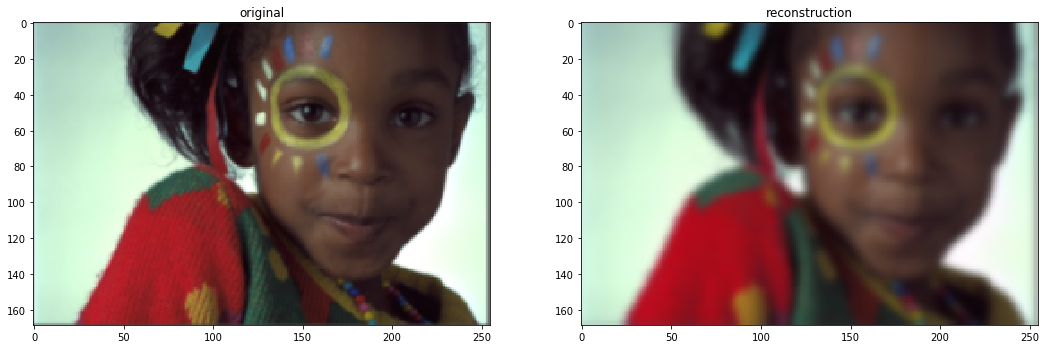

In [16]:
rgb_rec = np.zeros((n_h, n_w, 3))
rgb_orig = np.zeros((n_h, n_w, 3))

rgb_rec[:, :, RED] = rn_gs / rn_gs.max()
rgb_rec[:, :, GREEN] = gn_gs / gn_gs.max()
rgb_rec[:, :, BLUE] = bn_gs / bn_gs.max()

rgb_orig[:, :, RED] = red_gs / red_gs.max()
rgb_orig[:, :, GREEN] = green_gs / green_gs.max()
rgb_orig[:, :, BLUE] = blue_gs / blue_gs.max()


plt.figure(figsize=(18, 10))
ax = plt.subplot(1, 2, 1)
ax.set_title('original')
plt.imshow(rgb_orig, interpolation='nearest')

ax = plt.subplot(1, 2, 2)
ax.set_title('reconstruction')
plt.imshow(rgb_rec, interpolation='nearest')


plt.show()

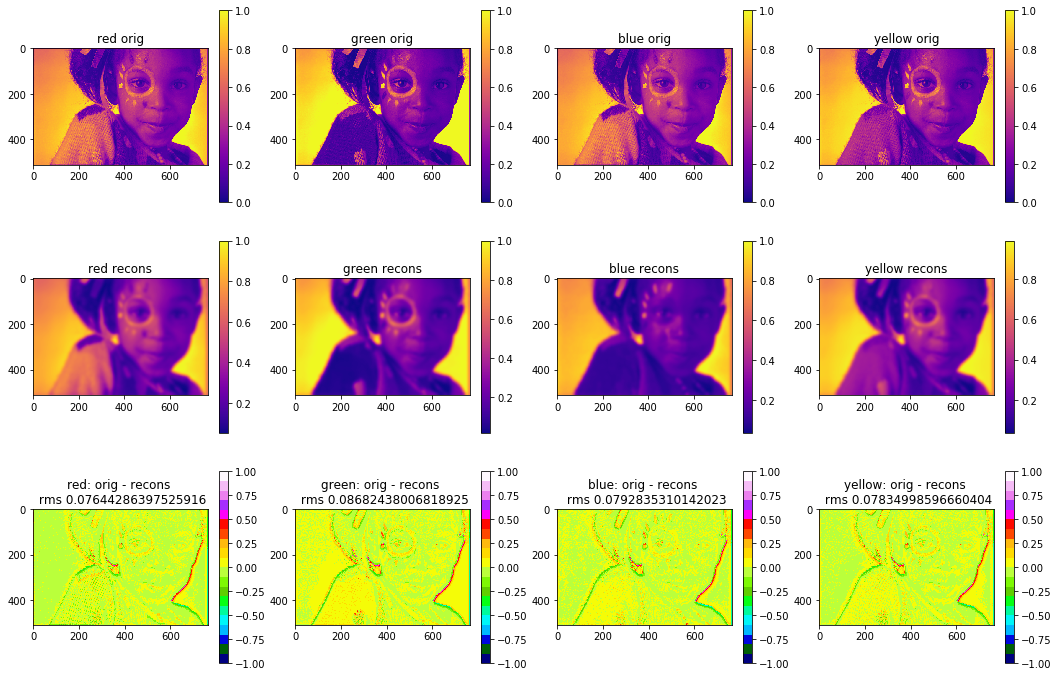

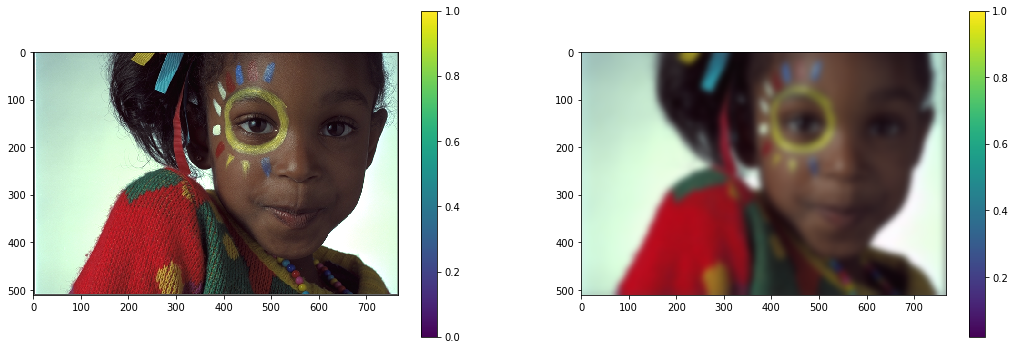

In [17]:
rec_big = cv2.resize(rgb_rec, (face.shape[1], face.shape[0]), interpolation=cv2.INTER_LINEAR)
rec_big[:, :, RED] *= 1.0 / rec_big[:, :, RED].max()
rec_big[:, :, GREEN] *= 1.0 / rec_big[:, :, GREEN].max()
rec_big[:, :, BLUE] *= 1.0 / rec_big[:, :, BLUE].max()

acr = achromatic/achromatic.max()

rec_big_r = rec_big[:, :, RED]
rec_big_g = rec_big[:, :, GREEN]
rec_big_b = rec_big[:, :, BLUE]
rec_big_y = YRED * rec_big_r + YGREEN * rec_big_g

sx = 3
sy = 5
diff_big_r = red[sy:, sx:] - rec_big_r[:-sy, :-sx]
diff_big_g = green[sy:, sx:] - rec_big_g[:-sy, :-sx]
diff_big_b = blue[sy:, sx:] - rec_big_b[:-sy, :-sx]
diff_big_y = yellow[sy:, sx:] - rec_big_y[:-sy, :-sx]

# diff_cmap = discrete_cmap(20, 'coolwarm')
diff_cmap = 'plasma'

plt.figure(figsize=(3*fw, 2.0*fw))
ax = plt.subplot(3, 4, 1)
ax.set_title("red orig")
im = plt.imshow(red, cmap=diff_cmap)#, vmin=-vmax, vmax=vmax)
plt.colorbar(im)

ax = plt.subplot(3, 4, 2)
ax.set_title("green orig")
im = plt.imshow(green, cmap=diff_cmap)#, vmin=-vmax, vmax=vmax)
plt.colorbar(im)

ax = plt.subplot(3, 4, 3)
ax.set_title("blue orig")
im = plt.imshow(red, cmap=diff_cmap)#, vmin=-vmax, vmax=vmax)
plt.colorbar(im)

ax = plt.subplot(3, 4, 4)
ax.set_title("yellow orig")
im = plt.imshow(yellow, cmap=diff_cmap)#, vmin=-vmax, vmax=vmax)
plt.colorbar(im)

# -------------------------------------------------- #


ax = plt.subplot(3, 4, 5)
ax.set_title("red recons")
im = plt.imshow(rec_big_r, cmap=diff_cmap)#, vmin=-vmax, vmax=vmax)
plt.colorbar(im)

ax = plt.subplot(3, 4, 6)
ax.set_title("green recons")
im = plt.imshow(rec_big_g, cmap=diff_cmap)#, vmin=-vmax, vmax=vmax)
plt.colorbar(im)

ax = plt.subplot(3, 4, 7)
ax.set_title("blue recons")
im = plt.imshow(rec_big_b, cmap=diff_cmap)#, vmin=-vmax, vmax=vmax)
plt.colorbar(im)

ax = plt.subplot(3, 4, 8)
ax.set_title("yellow recons")
im = plt.imshow(rec_big_y, cmap=diff_cmap)#, vmin=-vmax, vmax=vmax)
plt.colorbar(im)

# -------------------------------------------------- #

# diff_cmap = 'coolwarm'
# diff_cmap = discrete_cmap(20, 'hsv')
diff_cmap = discrete_cmap(20, 'gist_ncar')

ax = plt.subplot(3, 4, 9)
ax.set_title("red: orig - recons \n rms {}".format(np.sqrt(np.mean(diff_big_r**2))))
im = plt.imshow(diff_big_r, cmap=diff_cmap, vmin=-vmax, vmax=vmax)
plt.colorbar(im)

ax = plt.subplot(3, 4, 10)
ax.set_title("green: orig - recons \n rms {}".format(np.sqrt(np.mean(diff_big_g**2))))
im = plt.imshow(diff_big_g, cmap=diff_cmap, vmin=-vmax, vmax=vmax)
plt.colorbar(im)

ax = plt.subplot(3, 4, 11)
ax.set_title("blue: orig - recons \n rms {}".format(np.sqrt(np.mean(diff_big_b**2))))
im = plt.imshow(diff_big_b, cmap=diff_cmap, vmin=-vmax, vmax=vmax)
plt.colorbar(im)

ax = plt.subplot(3, 4, 12)
ax.set_title("yellow: orig - recons \n rms {}".format(np.sqrt(np.mean(diff_big_y**2))))
im = plt.imshow(diff_big_y, cmap=diff_cmap, vmin=-vmax, vmax=vmax)
plt.colorbar(im)


fig = plt.figure(figsize=(fw*3, fw))
ax = plt.subplot(1, 2, 1)
im = plt.imshow(face, interpolation='nearest')
plt.colorbar(im)

ax = plt.subplot(1, 2, 2)
im = plt.imshow(rec_big, interpolation='nearest')
plt.colorbar(im)

plt.show()

---

---

Now go for full resolution. 
---
Convert spikes into 'image'; just put them in the appropriate location.

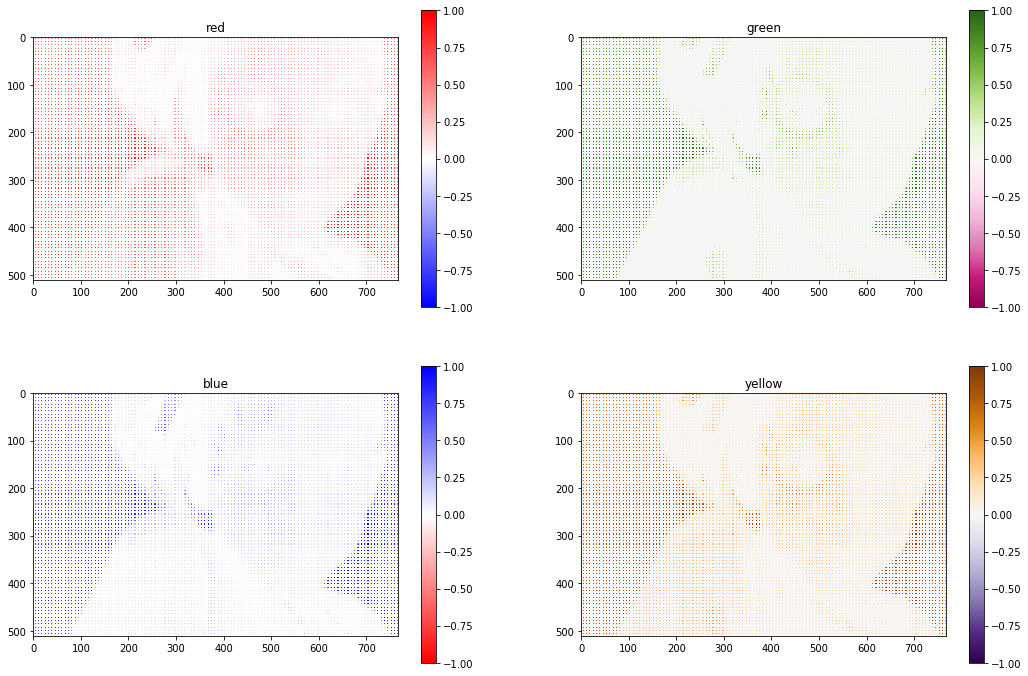

In [18]:
# rn_gs = rn_s.copy()
# gn_gs = gn_s.copy()
# bn_gs = bn_s.copy()
# yn_gs = yn_s.copy()
rn = np.zeros_like(red)
gn = rn.copy()
bn = rn.copy()
yn = rn.copy()

for i in range(len(_neuron_indices0)):
    v = _neuron_values0[i]
    idx = _neuron_indices0[i]
    img_idx = _img_indices0[i]
    row, col = rows[idx], cols[idx]
    
    if img_idx == R:
        rn[row, col] = v
    elif img_idx == G:
        gn[row, col] = v

for i in range(len(_neuron_indices1)):
    v = _neuron_values1[i]
    idx = _neuron_indices1[i]
    img_idx = _img_indices1[i]
    row, col = rows[idx], cols[idx]

    if img_idx == 0:
        bn[row, col] = v
    elif img_idx == 1:
        yn[row, col] = v

red_from_yellow = (yn - YGREEN * gn) / YRED
green_from_yellow = (yn - YRED * rn) / YGREEN
        
plt.figure(figsize=(3*fw, 2*fw))
ax = plt.subplot(2, 2, 1)
ax.set_title("red")
im = plt.imshow(rn, cmap='bwr', vmin=-np.abs(rn).max(), vmax=np.abs(rn).max())
plt.colorbar(im)

ax = plt.subplot(2, 2, 2)
ax.set_title("green")
im = plt.imshow(gn, cmap='PiYG', vmin=-np.abs(gn).max(), vmax=np.abs(gn).max())
plt.colorbar(im)

ax = plt.subplot(2, 2, 3)
ax.set_title("blue")
im = plt.imshow(bn, cmap='bwr_r', vmin=-np.abs(bn).max(), vmax=np.abs(bn).max())
plt.colorbar(im)


ax = plt.subplot(2, 2, 4)
ax.set_title("yellow")
im = plt.imshow(yn, cmap='PuOr_r', vmin=-np.abs(yn).max(), vmax=np.abs(yn).max())
plt.colorbar(im)

plt.show()

Apply a convolution to the spike images to reconstruct the original signal

[0.00426580581671188, 0.004277866078908687, 0.004249750623651737, 0.004262905715484793]
0.004277866078908687


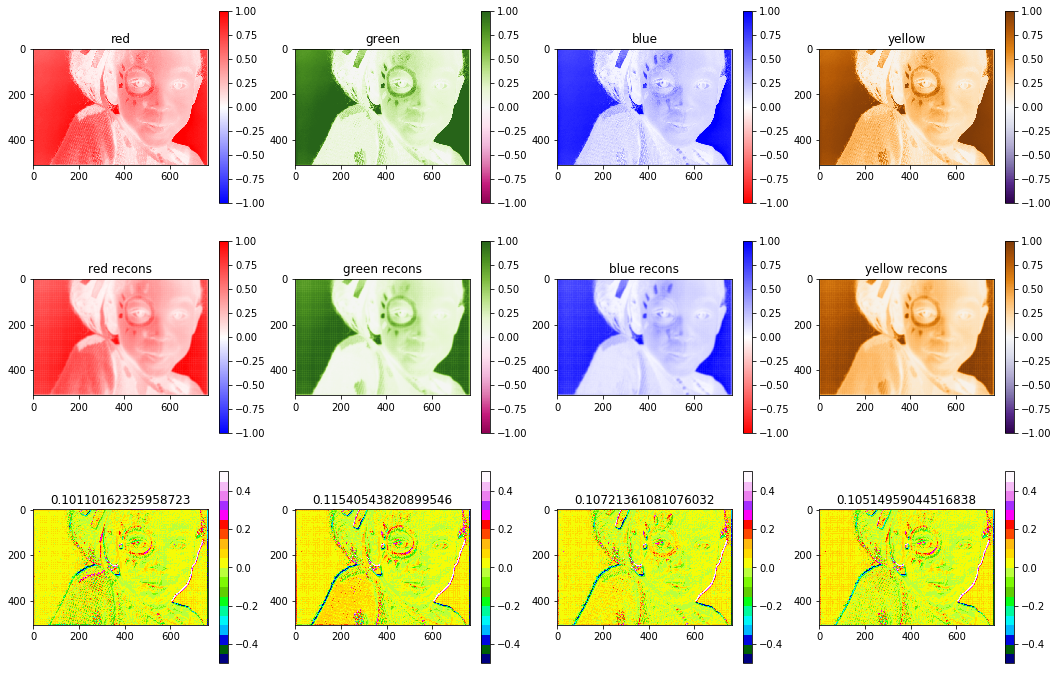

In [19]:
kernel = g1d if bool(1) else c1d

# img[:, :, 0] = rnc + (rnc == 0) * ((ync - YRED * gnc)/YGREEN)
# img[:, :, 1] = gnc + (gnc == 0) * ((ync - YGREEN * rnc)/YRED)

if bool(0):
    red_from_yellow = (yn - YGREEN * gn) / YRED
    red_from_yellow *= (red_from_yellow > 0)
    
    green_from_yellow = (yn - YRED * rn) / YGREEN
    green_from_yellow *= (green_from_yellow > 0)
    
    rn0 = rn + (rn == 0) * red_from_yellow
    gn0 = gn + (gn == 0) * green_from_yellow
else:
    rn0 = rn 
    gn0 = gn 
    
rnc = convolve(rn0, kernel) 
gnc = convolve(gn0, kernel) 
bnc = convolve(bn, kernel) 
ync = convolve(yn, kernel) 



print([rnc.max(), gnc.max(), bnc.max(), ync.max()])
maxv = np.max([rnc.max(), gnc.max(), bnc.max(), ync.max()])
print(maxv)


if bool(0):
    red_from_yellow = (ync - YGREEN * gnc) / YRED
#     red_from_yellow *= (red_from_yellow > 0)
    
    green_from_yellow = (ync - YRED * rnc) / YGREEN
#     green_from_yellow *= (green_from_yellow > 0)
    
    rnc[:] += (rnc == 0) * red_from_yellow
    gnc[:] += (gnc == 0) * green_from_yellow

if bool(1):
    rnc *= 1./rnc.max()
    gnc *= 1./gnc.max()
    bnc *= 1./bnc.max()
    ync *= 1./ync.max()
#     bnc *= (YGREEN + YRED)/bnc.max()
#     ync *= (YGREEN + YRED)/ync.max()
# else:
#     rnc[:] = np.clip((0 + rnc) * 2.55, 0, 255)
#     gnc[:] = np.clip((0 + gnc) * 2.55, 0, 255)
#     bnc[:] = np.clip((0 + bnc) * 2.55, 0, 255)


rnc[:] = np.clip(rnc, 0., 1.)
gnc[:] = np.clip(gnc, 0., 1.)
bnc[:] = np.clip(bnc, 0., 1.)
ync[:] = np.clip(ync, 0., 1.)


sx = 3
sy = 5
diff_r = red[sy:, sx:] - rnc[:-sy, :-sx]
diff_g = green[sy:, sx:] - gnc[:-sy, :-sx]
diff_b = blue[sy:, sx:] - bnc[:-sy, :-sx]
diff_y = yellow[sy:, sx:] - ync[:-sy, :-sx]


plt.figure(figsize=(3*fw, 2*fw))
ax = plt.subplot(3, 4, 1)
ax.set_title("red")
im = plt.imshow(red, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(im)

ax = plt.subplot(3, 4, 2)
ax.set_title("green")
im = plt.imshow(green, cmap='PiYG', vmin=-1, vmax=1)
plt.colorbar(im)

ax = plt.subplot(3, 4, 3)
ax.set_title("blue")
im = plt.imshow(blue, cmap='bwr_r', vmin=-1, vmax=1)
plt.colorbar(im)

ax = plt.subplot(3, 4, 4)
ax.set_title("yellow")
im = plt.imshow(yellow, cmap='PuOr_r', vmin=-1, vmax=1)
plt.colorbar(im)


ax = plt.subplot(3, 4, 5)
ax.set_title("red recons")
im = plt.imshow(rnc, cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(im)

ax = plt.subplot(3, 4, 6)
ax.set_title("green recons")
im = plt.imshow(gnc, cmap='PiYG', vmin=-1, vmax=1)
plt.colorbar(im)

ax = plt.subplot(3, 4, 7)
ax.set_title("blue recons")
im = plt.imshow(bnc, cmap='bwr_r', vmin=-1, vmax=1)
plt.colorbar(im)

ax = plt.subplot(3, 4, 8)
ax.set_title("yellow recons")
im = plt.imshow(ync, cmap='PuOr_r', vmin=-1, vmax=1)
plt.colorbar(im)


# diff_cmap = 'Set3'
diff_cmap = discrete_cmap(20, 'cubehelix')
diff_cmap = discrete_cmap(20, 'gist_ncar')


vmax = 0.5
ax = plt.subplot(3, 4, 9)
ax.set_title("difference: red")
ax.set_title(np.sqrt(np.mean(diff_r**2)))
im = plt.imshow(diff_r, cmap=diff_cmap, vmin=-vmax, vmax=vmax)
plt.colorbar(im)

ax = plt.subplot(3, 4, 10)
ax.set_title("difference: green")
ax.set_title(np.sqrt(np.mean(diff_g**2)))
im = plt.imshow(diff_g, cmap=diff_cmap, vmin=-vmax, vmax=vmax)
plt.colorbar(im)

ax = plt.subplot(3, 4, 11)
ax.set_title("difference: blue")
ax.set_title(np.sqrt(np.mean(diff_b**2)))
im = plt.imshow(diff_b, cmap=diff_cmap, vmin=-vmax, vmax=vmax)
plt.colorbar(im)

ax = plt.subplot(3, 4, 12)
ax.set_title("difference: yellow")
ax.set_title(np.sqrt(np.mean(diff_y**2)))
im = plt.imshow(diff_y, cmap=diff_cmap, vmin=-vmax, vmax=vmax)
plt.colorbar(im)

plt.show()

Merge per-channel images into a single color image and compare to original

1.0


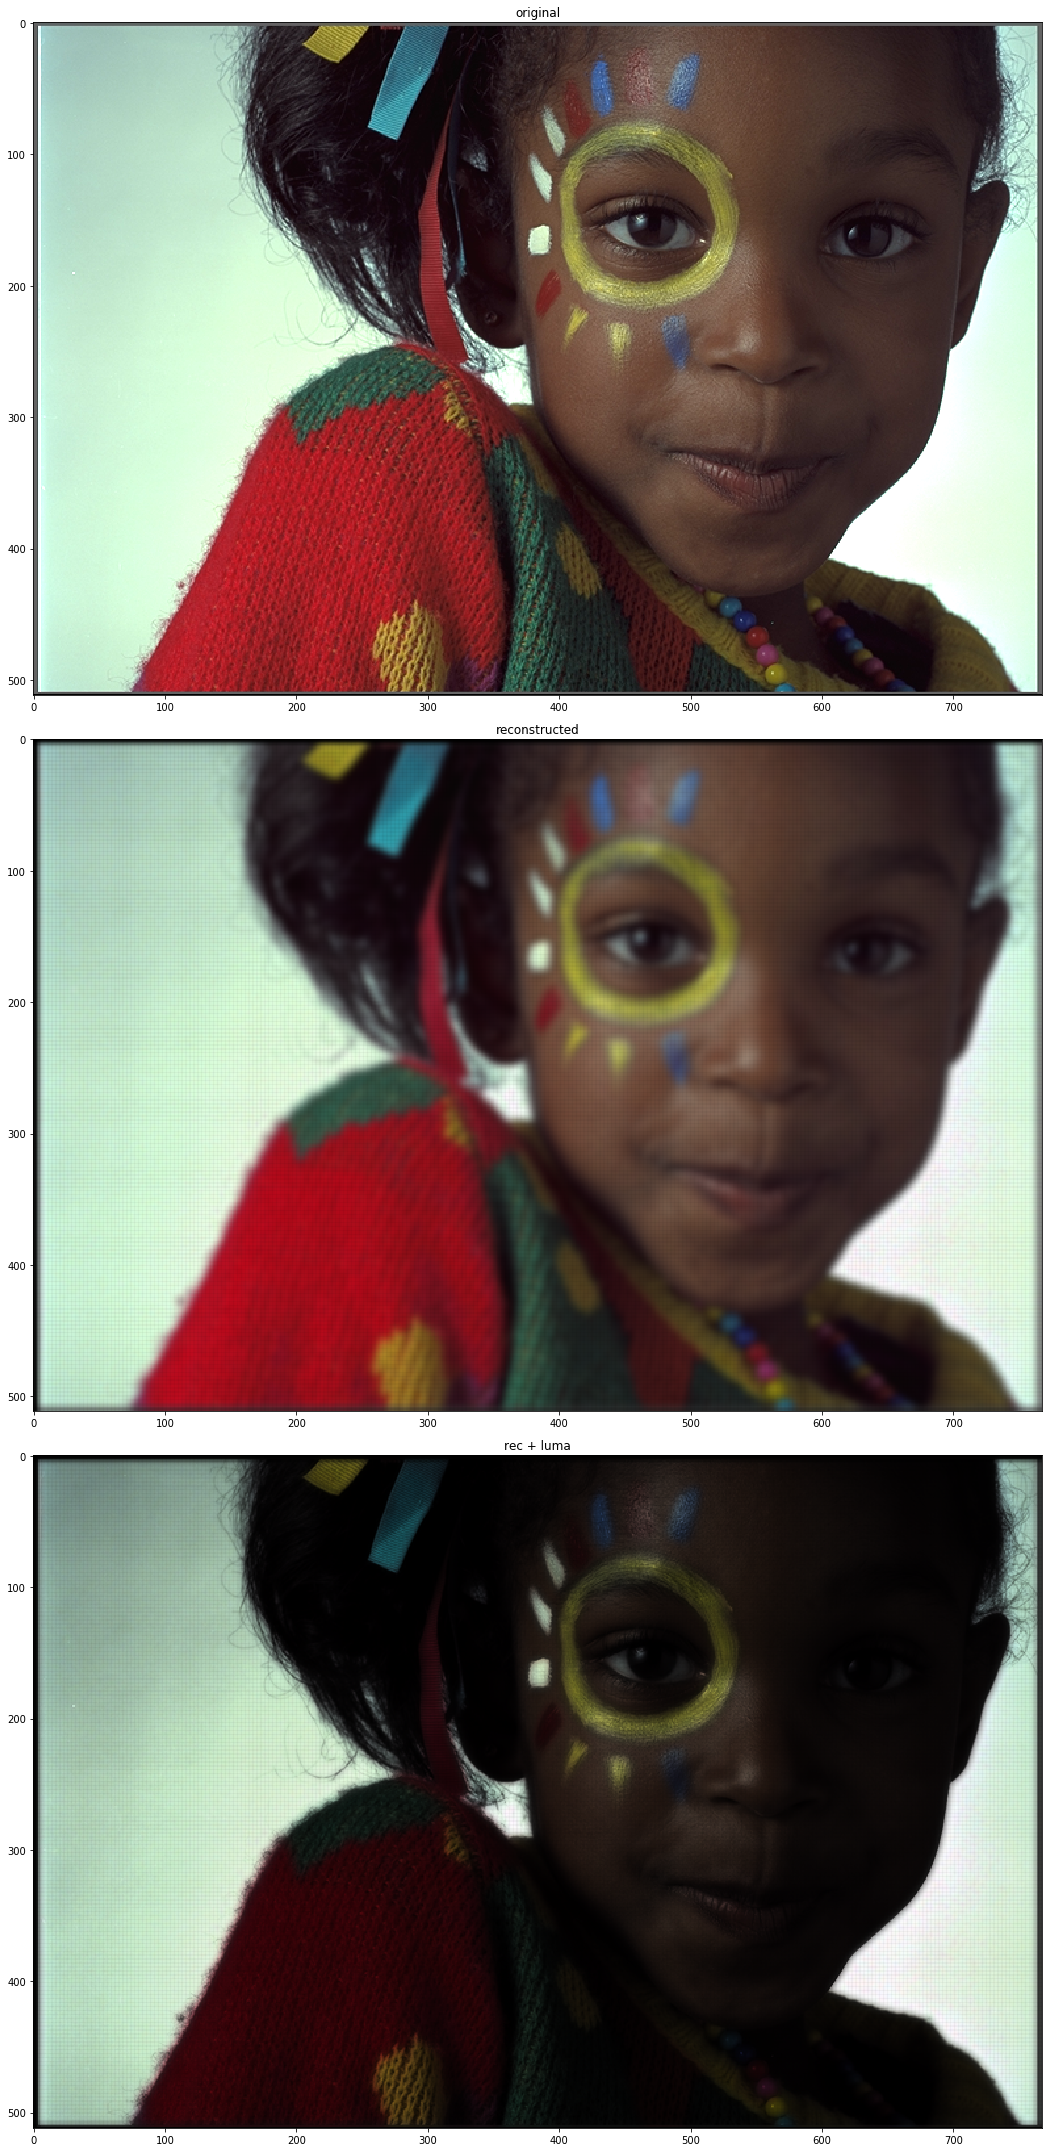

In [20]:
img = np.zeros((h0, w0, 3))
# (yellow_out - AGREEN * green_out)/ARED
eps = 1e-12
img[:, :, 0] = rnc #/ rnc.max()#+ (rnc <= eps) * ((ync - YRED * rnc)/YGREEN)
img[:, :, 1] = gnc #/ gnc.max() #+ (gnc <= eps) * ((ync - YGREEN * gnc)/YRED)
img[:, :, 2] = bnc #/ bnc.max()
print(img.max())

alpha = 0.0
acr = achromatic[:, :, np.newaxis]/achromatic.max()
my_img = img.copy()# ((1.0 - alpha)) * img + (acr * alpha)
my_img *= 1.0*acr

fw = 10
plt.figure(figsize=(2*fw, 3*fw))

ax = plt.subplot(3, 1, 1)
ax.set_title("original")
im = plt.imshow(face, interpolation='nearest')

ax = plt.subplot(3, 1, 2)
ax.set_title("reconstructed")
im = plt.imshow(img/img.max(), interpolation='nearest')

ax = plt.subplot(3, 1, 3)
ax.set_title("rec + luma")
im = plt.imshow(my_img, interpolation='nearest')

plt.tight_layout()
plt.savefig('reconstruction.png')
plt.show()

        